In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import boto3
import botocore
import matplotlib.image as mpimg

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO, BytesIO
from matplotlib import pyplot as plt
from PIL import Image

#Env Setup
# This is (maybe?) needed to display the images.
%matplotlib inline

#object detection imports
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import ops as utils_ops


In [5]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

def get_frozen_graph():
    # What model to download.
    MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
    MODEL_FILE = MODEL_NAME + '.tar.gz'
    DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
    PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
    PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

    #Load frozen detection graph
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
    return detection_graph, category_index

detection_graph, category_index = get_frozen_graph()

/home/dschuler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods


In [6]:
BUCKET_NAME = 'trialbucketportaltech'
PATH_TO_TEST_IMAGES_DIR = 'test-images/image1.jpg'

In [7]:
s3 = boto3.resource('s3')
bucket = s3.Bucket(BUCKET_NAME)
image = bucket.Object(PATH_TO_TEST_IMAGES_DIR)

img = mpimg.imread(BytesIO(image.get()['Body'].read()), 'jpg')

Hello World


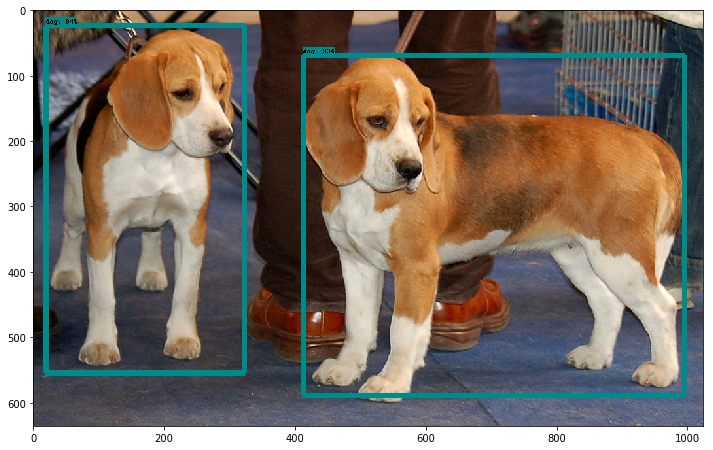

In [9]:
IMAGE_SIZE = (12, 8)
#image = Image.open(image_path)
image_np = img.copy()

# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
#image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
fig_path = '/tmp/tested_image.jpg' # should make a dir in S3 with timestamp for each image
plt.savefig(fig_path)
#return fig_path
print('Hello World')